<a href="https://colab.research.google.com/github/BrunoBertolinoSC/trabalho2_de_PDS/blob/main/Trabalho_2_PDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Achamos 10 arquivos. Usando FS=20000Hz.
--> Analisando: seg_0a97c4.csv


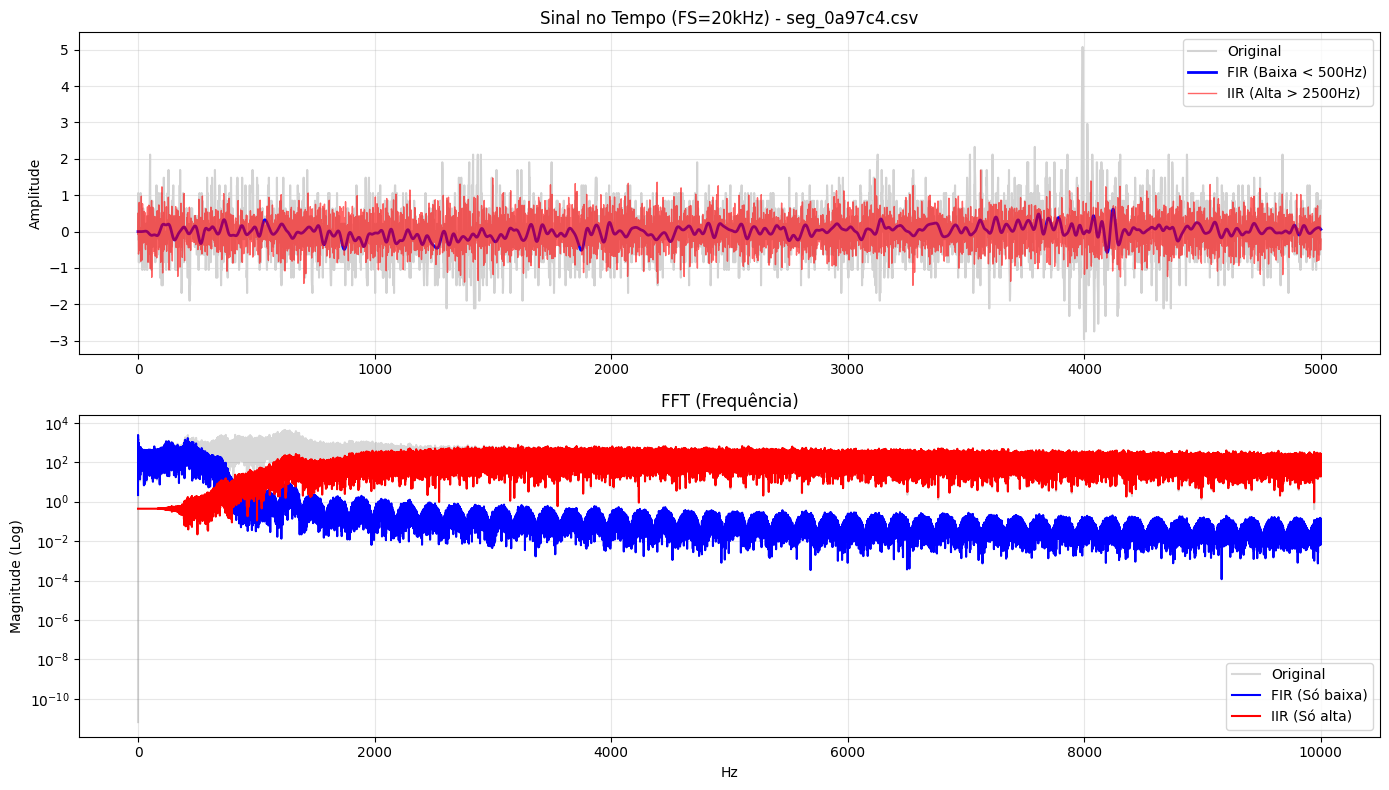

 Próximo...

--> Analisando: seg_0aa0fb.csv


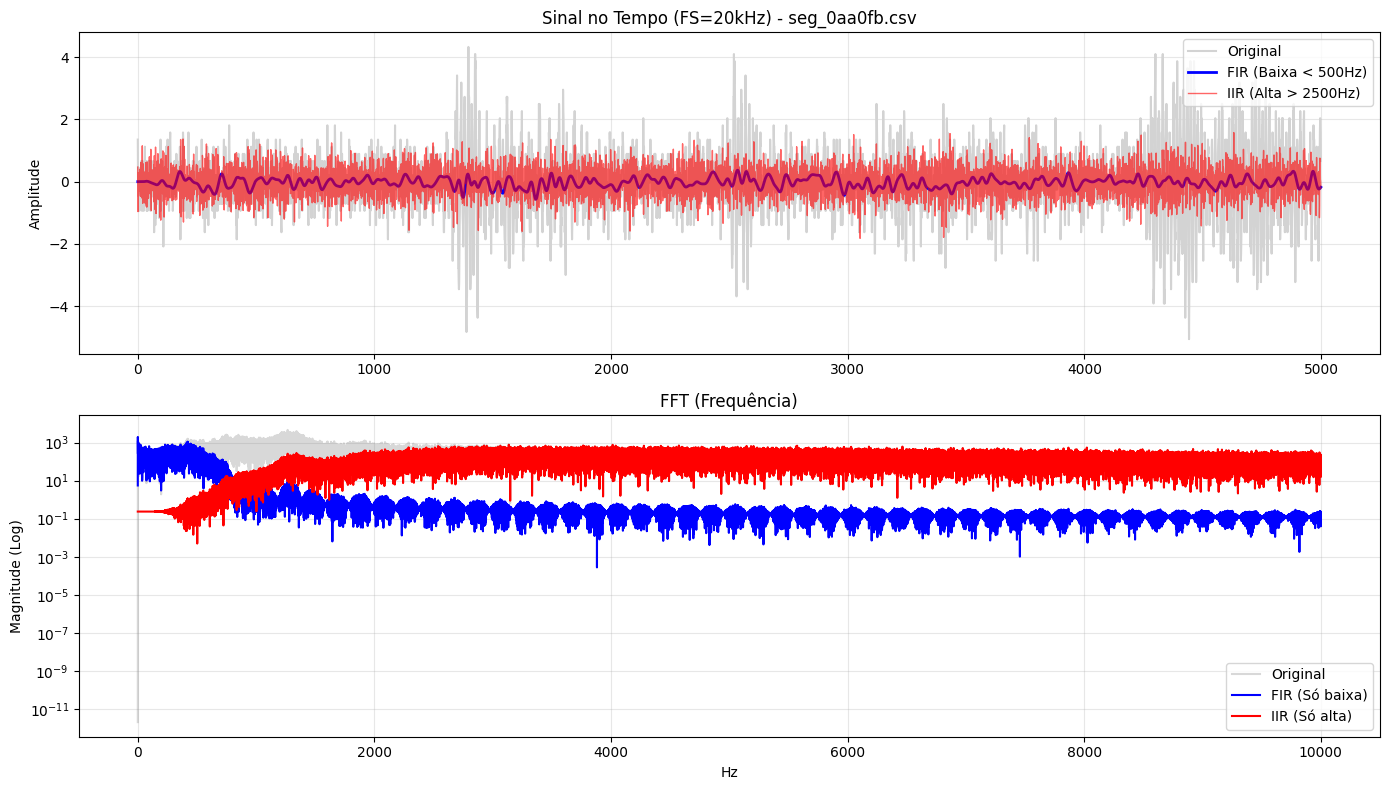

 Próximo...

--> Analisando: seg_0a42ba.csv


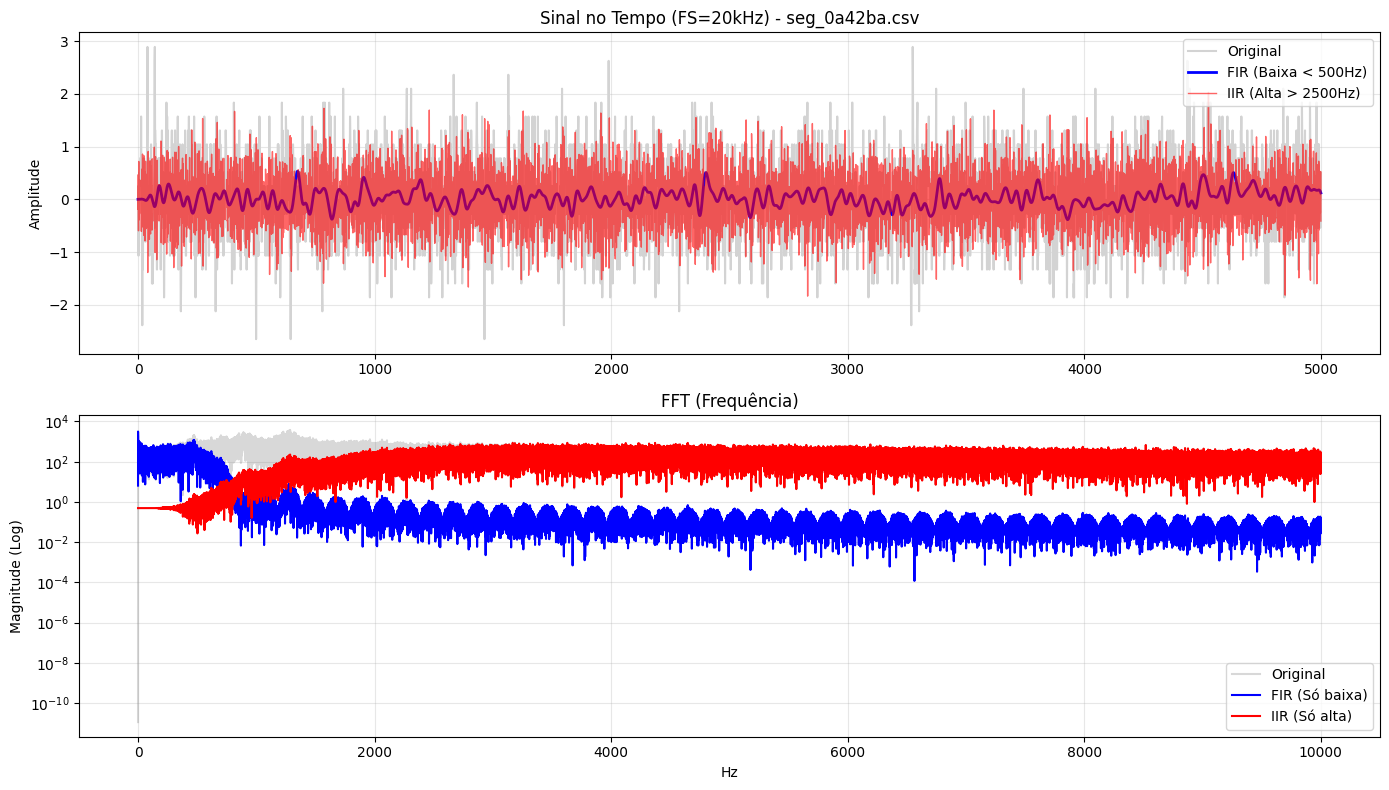

 Próximo...

--> Analisando: seg_0b3b94.csv


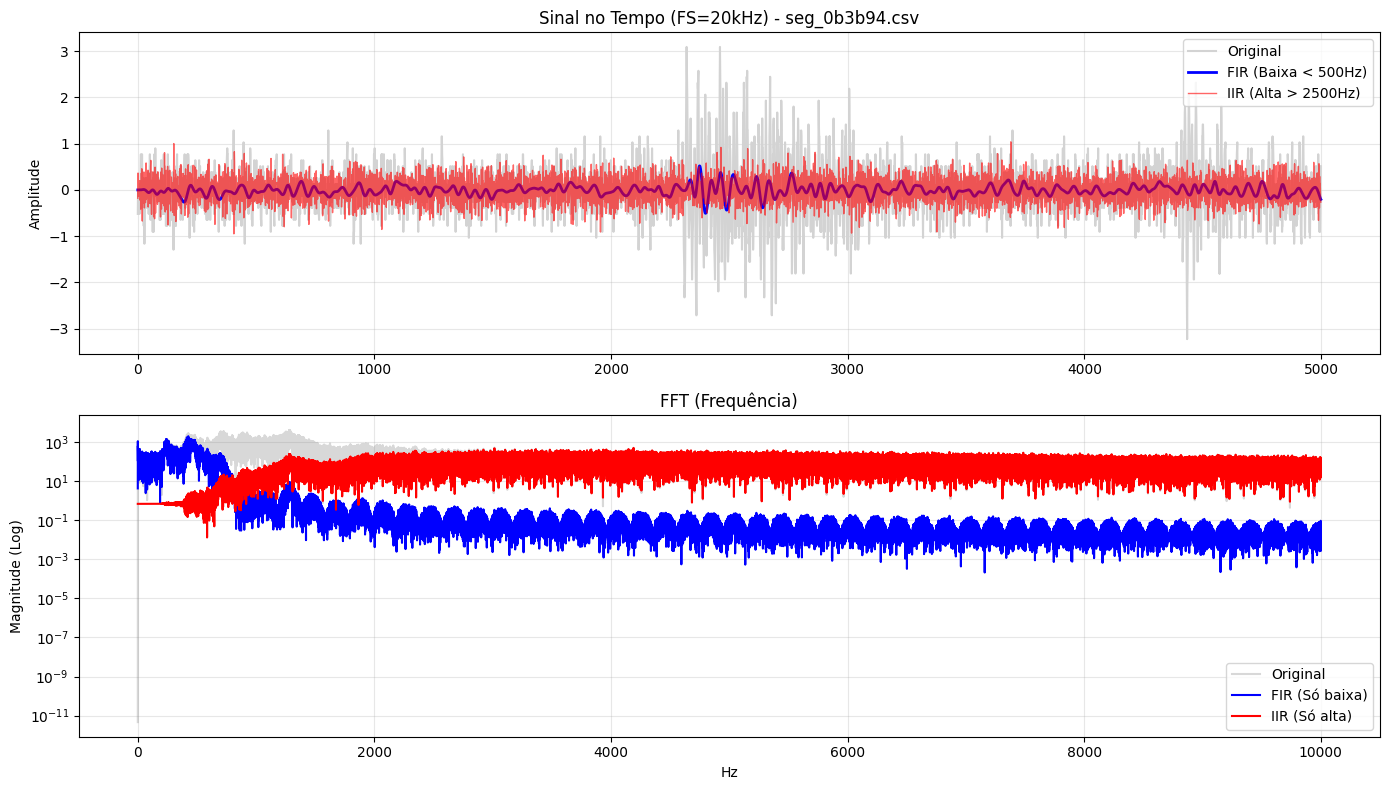

 Próximo...

--> Analisando: seg_0b4b24.csv


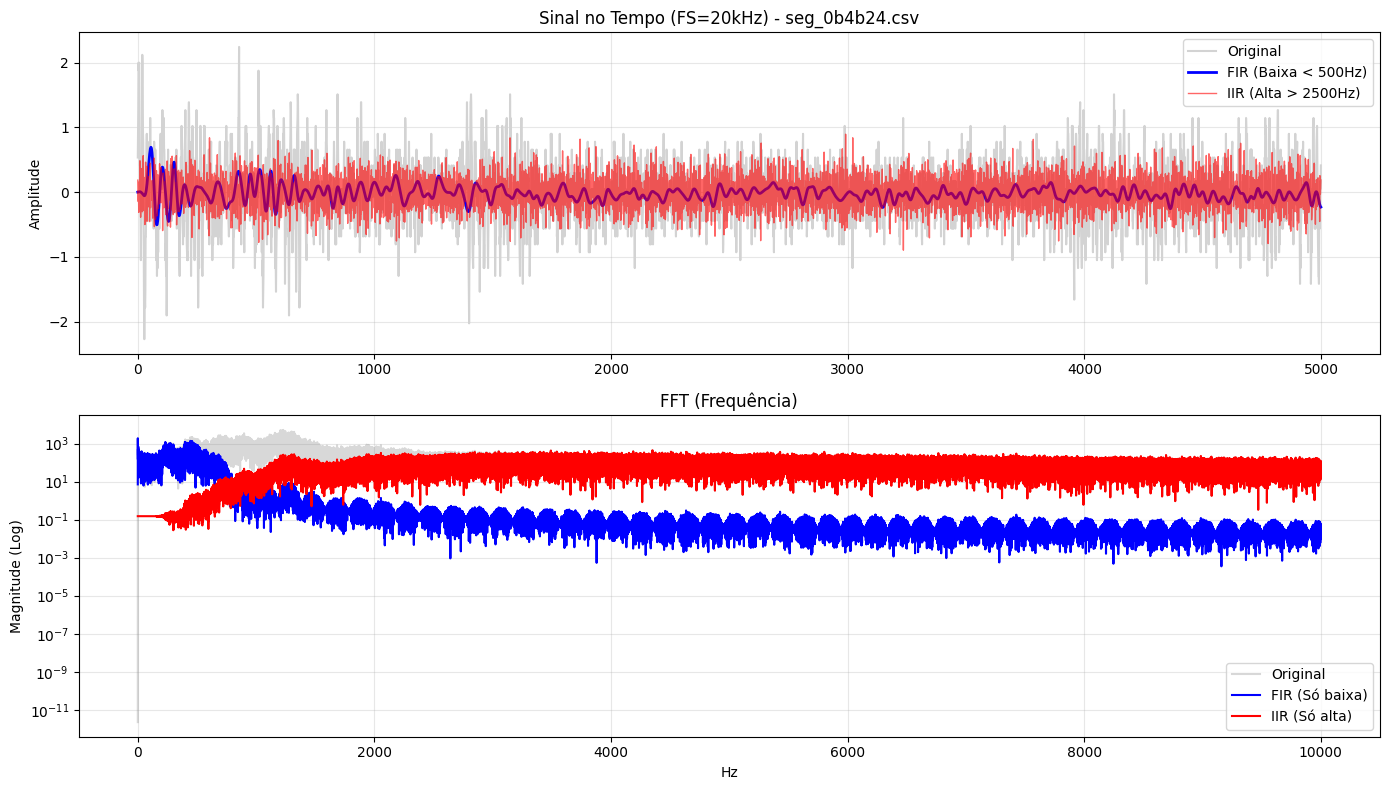

 Próximo...

--> Analisando: seg_0b07c7.csv


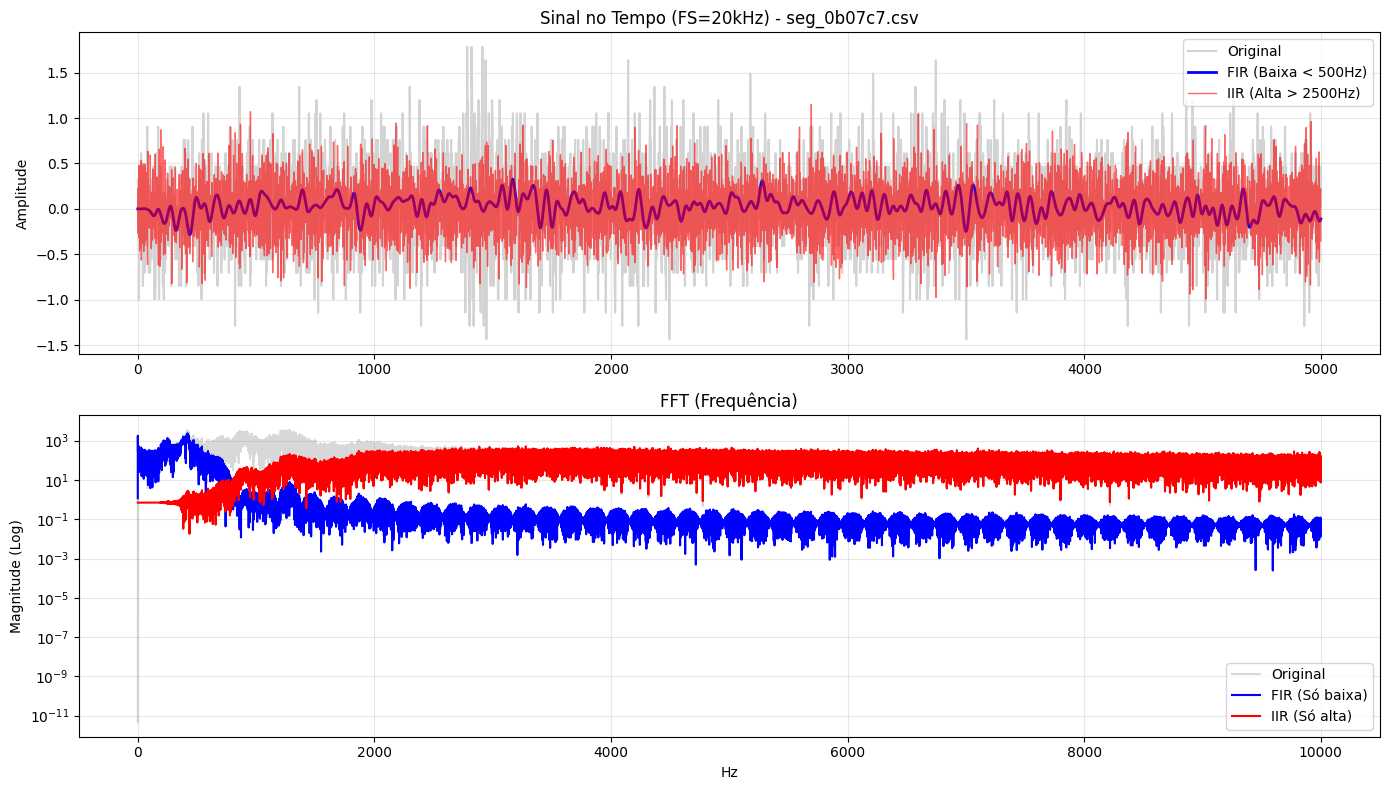

 Próximo...

--> Analisando: seg_0a0fbb.csv


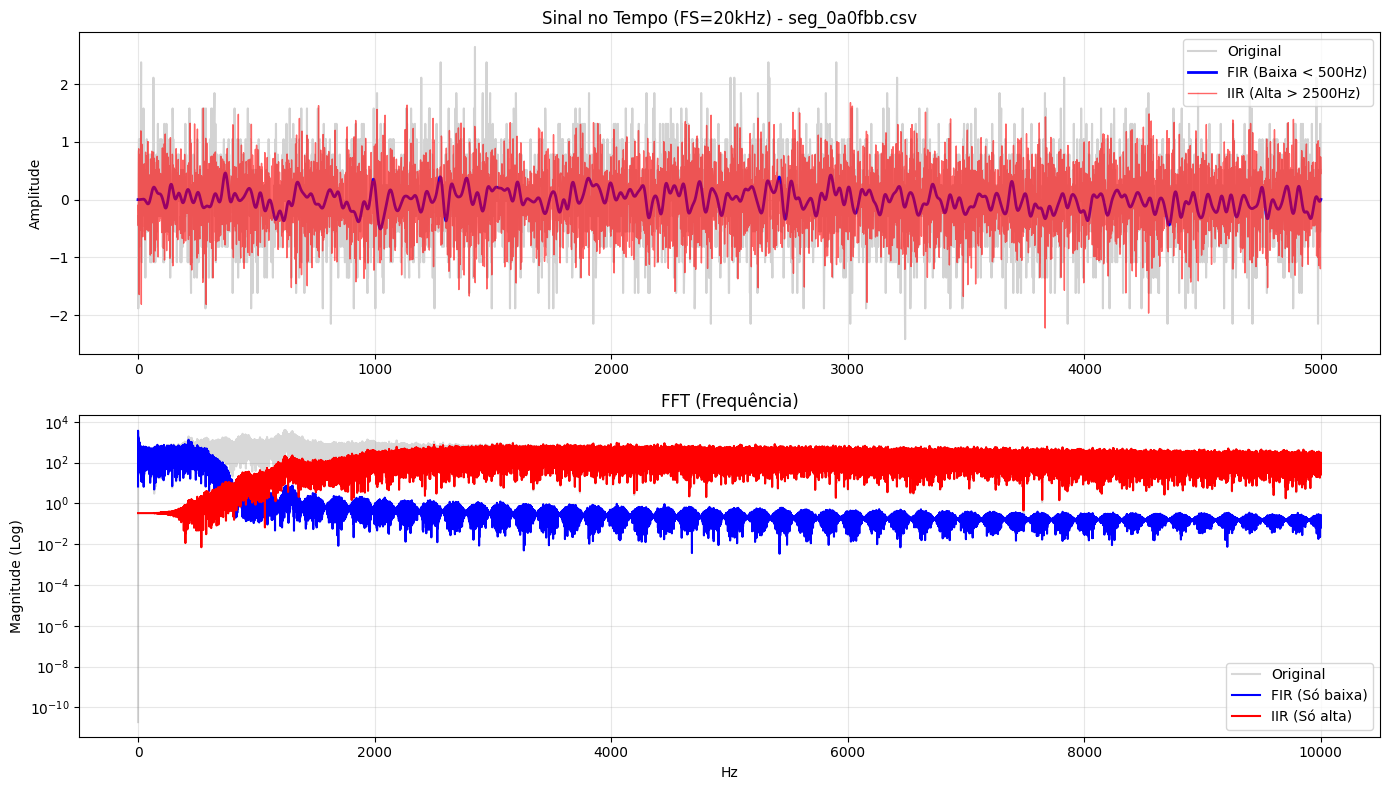

 Próximo...

--> Analisando: seg_00a37e.csv


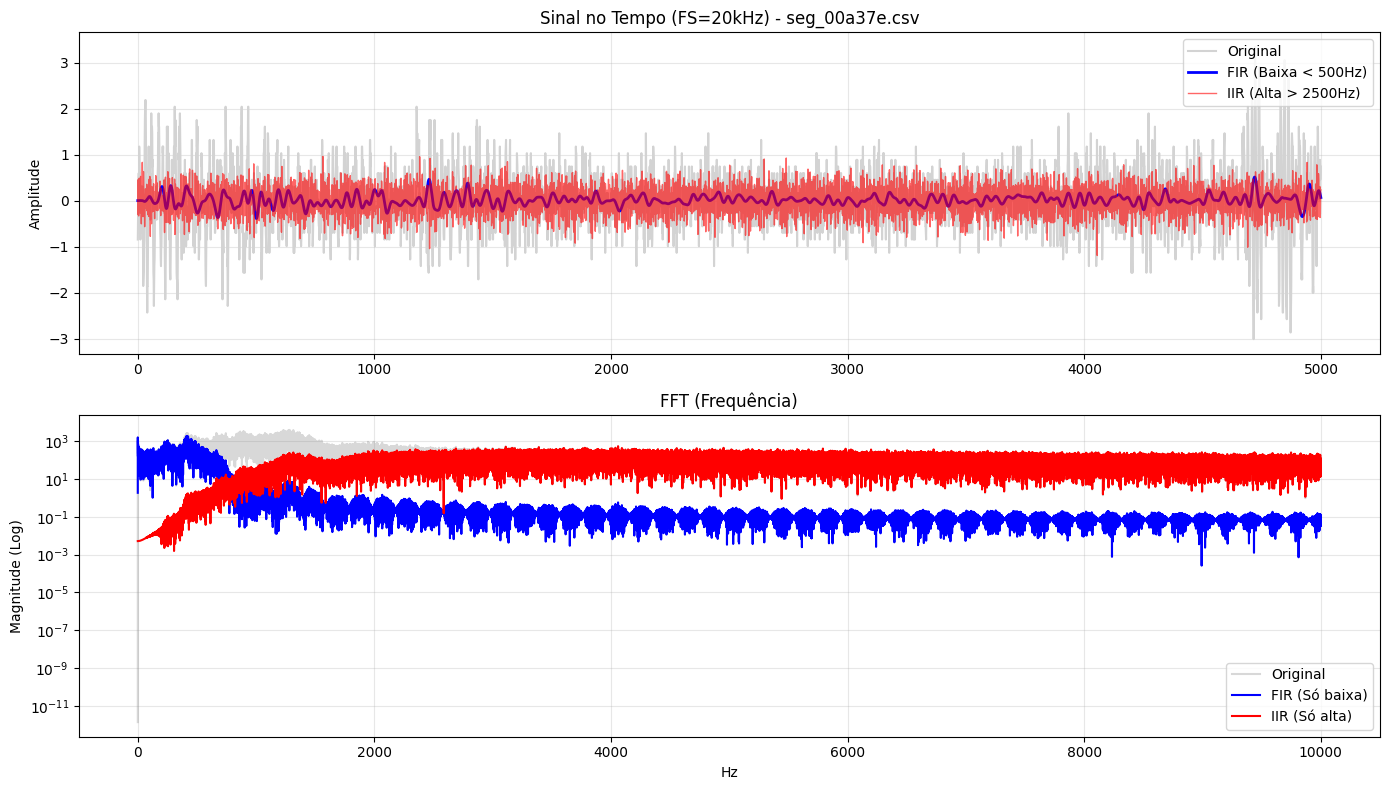

 Próximo...

--> Analisando: seg_0a1bd0.csv


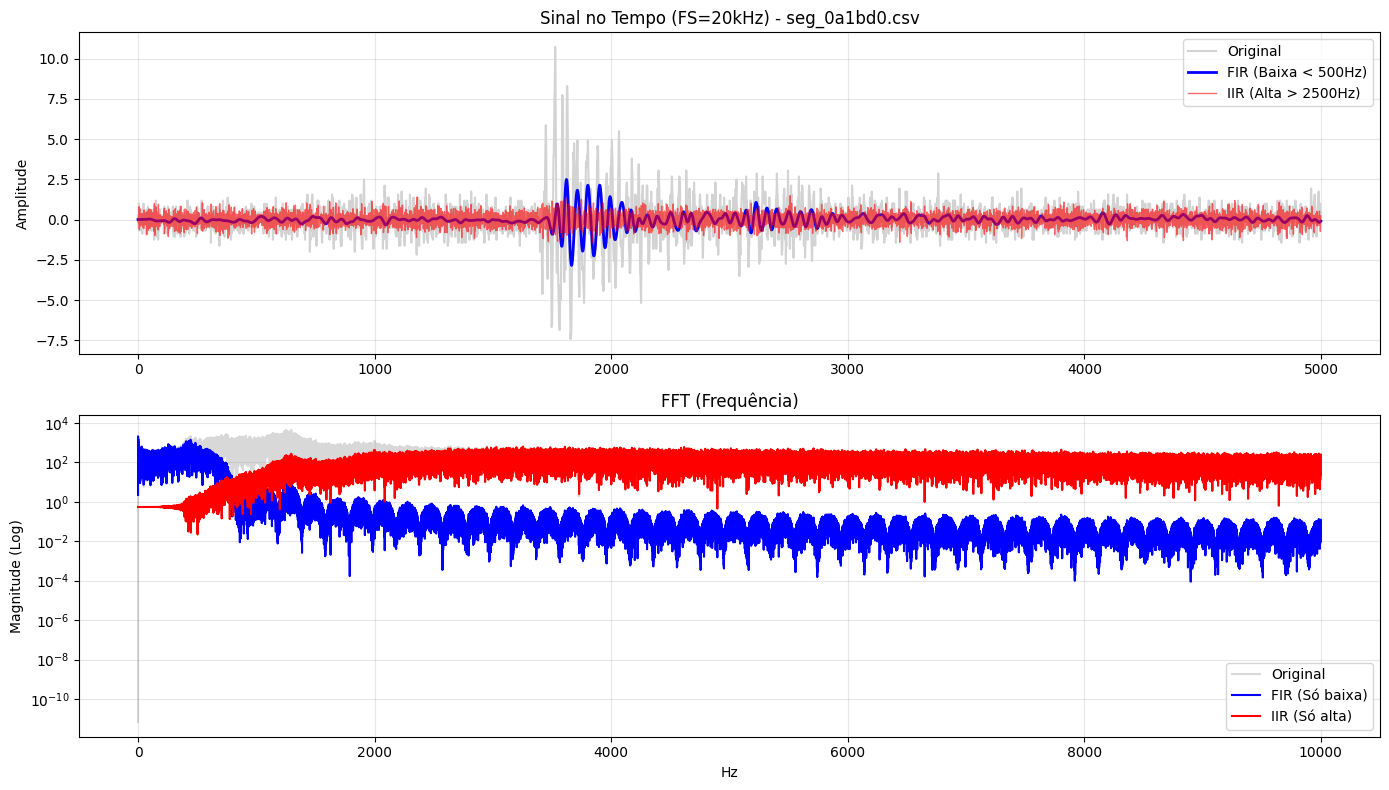

 Próximo...

--> Analisando: seg_0a45a1.csv


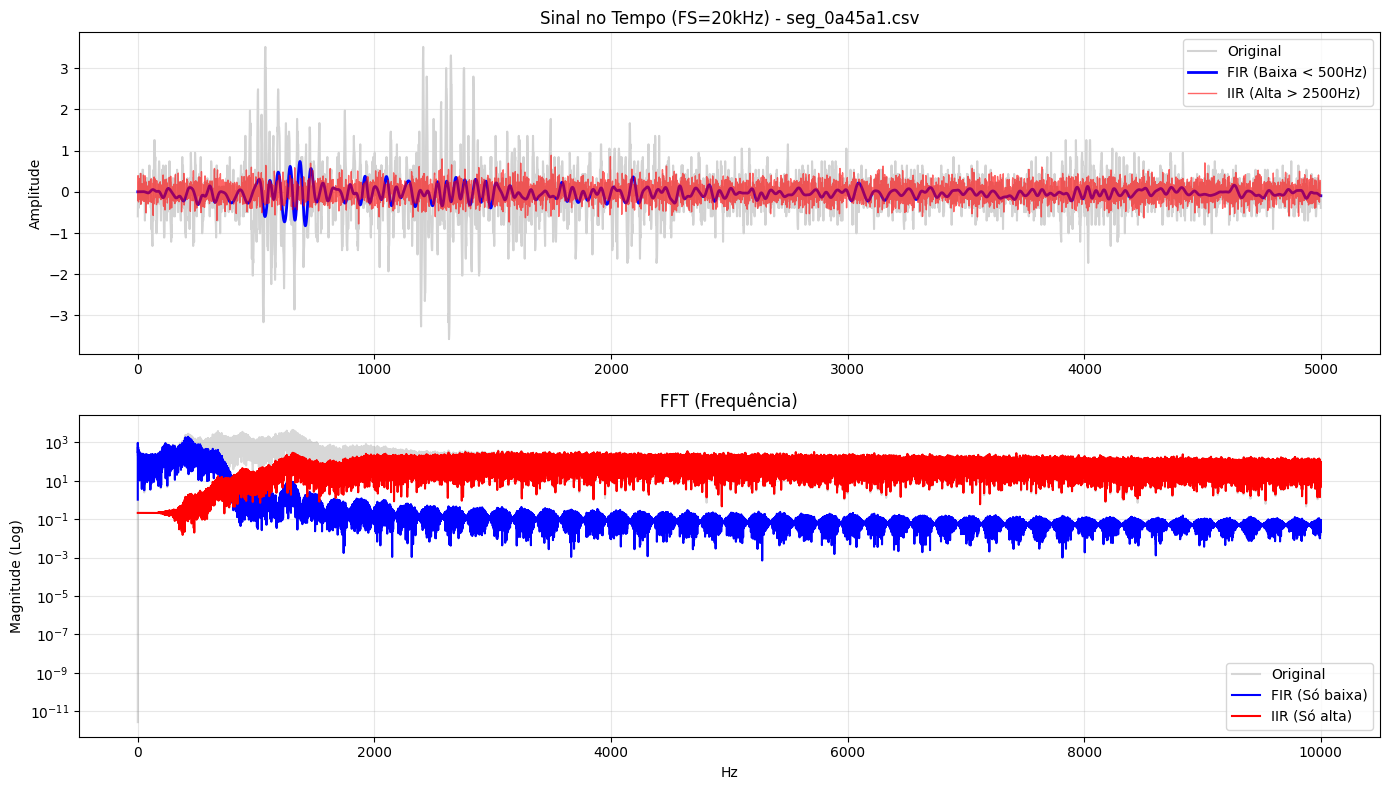

 Próximo...



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, firwin, lfilter, freqz
from scipy.fft import fft, fftfreq
import glob
import os

# ----------------------------------------------------------------
# CONFIGURAÇÃO DA FREQUÊNCIA
# ----------------------------------------------------------------
# O PDF diz que é cerca de 20kHz
FS = 20000
# O limite físico (Nyquist) é metade disso: 10.000 Hz
# Nossos filtros tem que estar abaixo de 10.000 Hz
NYQUIST = FS / 2

# ----------------------------------------------------------------
# Funções de Filtro
# ----------------------------------------------------------------

def fazer_filtro_fir(corte, taps):
    w_norm = corte / NYQUIST
    b = firwin(taps, w_norm, window='hamming')
    return b

def fazer_filtro_iir(corte, ordem):
    w_norm = corte / NYQUIST
    b, a = butter(ordem, w_norm, btype='high', analog=False)
    return b, a

def filtrar(sinal, b, a=1):
    return lfilter(b, a, sinal)

# ----------------------------------------------------------------
# Processamento
# ----------------------------------------------------------------

lista_arquivos = glob.glob('/content/dados_trabalho/*.csv')

if len(lista_arquivos) == 0:
    print("Ainda não achou os arquivos na pasta dados_trabalho")
else:
    print(f"Achamos {len(lista_arquivos)} arquivos. Usando FS={FS}Hz.")

for arquivo in lista_arquivos[:10]:
    nome = os.path.basename(arquivo)
    print(f"--> Analisando: {nome}")

    try:
        df = pd.read_csv(arquivo)
        sinal_cru = df['acoustic_data'].values.astype(float)

        # Normalizando (Z-score)
        sinal_norm = (sinal_cru - np.mean(sinal_cru)) / np.std(sinal_cru)

        # --- APLICANDO OS FILTROS ---

        # 1. FIR Passa-Baixa (Tendência)
        # Como o máximo é 10k, ajustamos em 500 Hz
        taps_fir = 101
        corte_fir = 500
        b_fir = fazer_filtro_fir(corte_fir, taps_fir)
        sinal_fir = filtrar(sinal_norm, b_fir)

        # 2. IIR Passa-Alta (Picos/Ruptura)
        # Pegamos de 2.5kHz pra cima
        ordem_iir = 4
        corte_iir = 2500
        b_iir, a_iir = fazer_filtro_iir(corte_iir, ordem_iir)
        sinal_iir = filtrar(sinal_norm, b_iir, a_iir)

        # --- GRÁFICOS ---

        limite_plot = 5000

        plt.figure(figsize=(14, 8))

        # Tempo
        plt.subplot(2, 1, 1)
        plt.title(f"Sinal no Tempo (FS=20kHz) - {nome}")
        plt.plot(sinal_norm[:limite_plot], label='Original', color='lightgray')
        plt.plot(sinal_fir[:limite_plot], label=f'FIR (Baixa < {corte_fir}Hz)', color='blue', linewidth=2)
        plt.plot(sinal_iir[:limite_plot], label=f'IIR (Alta > {corte_iir}Hz)', color='red', alpha=0.6, linewidth=1)
        plt.legend(loc='upper right')
        plt.grid(True, alpha=0.3)
        plt.ylabel("Amplitude")

        # Frequência (FFT)
        N = len(sinal_norm)
        yf_orig = fft(sinal_norm)
        yf_fir = fft(sinal_fir)
        yf_iir = fft(sinal_iir)
        xf = fftfreq(N, 1 / FS)

        metade = N // 2

        plt.subplot(2, 1, 2)
        plt.title("FFT (Frequência)")
        plt.semilogy(xf[:metade], np.abs(yf_orig[:metade]), label='Original', color='gray', alpha=0.3)
        plt.semilogy(xf[:metade], np.abs(yf_fir[:metade]), label='FIR (Só baixa)', color='blue')
        plt.semilogy(xf[:metade], np.abs(yf_iir[:metade]), label='IIR (Só alta)', color='red')
        plt.xlabel("Hz")
        plt.ylabel("Magnitude (Log)")
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        print(" Próximo...\n")

    except Exception as e:
        print(f"Erro no {nome}: {e}")
        continue